In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/histopathologic-cancer-detection/train_labels.csv
/kaggle/input/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
/kaggle/input/histopathologic-cancer-detection/test/5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
/kaggle/input/histopathologic-cancer-detection/test/bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
/kaggle/input/histopathologic-cancer-detection/test/523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
/kaggle/input/histopathologic-cancer-detection/test/d23c66547f4a00555a174d2fcb860ae399b66edc.tif
/kaggle/input/histopathologic-cancer-detection/test/fabf2fca23f71655974767e29eda86a9b2c97a72.tif
/kaggle/input/histopathologic-cancer-detection/test/9730b15862516b8641b9f0ff48db660d95031c32.tif
/kaggle/input/histopathologic-cancer-detection/test/ee85348c0950c2e639776fb555e3452c1f8437c

**Project Description:**

Histopathologic project involves craeting a model to identify metastatic cancer in small image patches.This is a binary classification project to check if the cancer is present in smaller patches.Class 0 indicates cancer is not present and Class 1 indicates cancer is present.

Class Distribution label
0    130908
1     89117

Submissions are evaluated on area under the ROC curve.

**Cancer Detection Project - Introduction to Deep Learning**

This project involves the following basic steps:

**1)Import and Load the dataset in Panads dataframes**

**2)Exploratory Data Analysis**

a)Check the first 5 rows , shape of the dataset,checking duplicates,null values
b)Label Distribution Plot
c)Random Sample Visualization
d)Check the pixel intensity values across the R,G and B channels
e)Kde plot
f)Summary Statistics

**3)Data Preprocessing**

Step 1: Splitting into train/test set
Step 2: Reducing the number of samples for faster processing
Step 3: Generators

**4)Model Architecture** 

Step 1: Sequential Model/Validation Accuracy and Plot
Step 2: Keras Tuner (Hyper parameter Optimization)
Step 3: RESNET Model 

**5)Hyperparameter Tuning**

Checking the validation accuracy of different models & Plotting the results

**6)Submissions for accuracy score** 

**7)Conclusion**

**8)References**

# 1.Import the Libraries and Load the dataset

In [1]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import warnings
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# 2.Exploratory Data Analysis

a)Check the first 5 rows , shape of the dataset,checking duplicates,null values b)Label Distribution Plot c)Random Sample Visualization d)Check the pixel intensity values across the R,G and B channels e)Kde plot f)Summary Statistics

First 5 rows:
                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Training Labels shape: (220025, 2)


Missing Values in training data

id       0
label    0
dtype: int64


Check for duplicates
 0


Class Distribution label
0    130908
1     89117
Name: count, dtype: int64




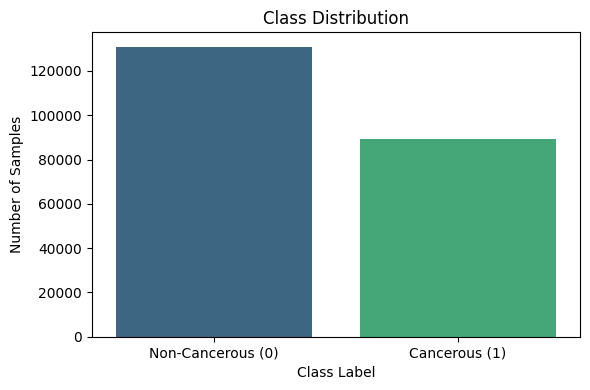

In [3]:
#Exploratoty Data Analysis

#Print the first 5 rows in the dataset
print("First 5 rows:\n",df.head())

print("\n") #Shape
print("Training Labels shape:",df.shape)

print("\n") #Check Missisng Values
print("Missing Values in training data\n")
print(df.isnull().sum())

print("\n") #Check duplicates
duplicates = df.duplicated().sum()
print("Check for duplicates\n",duplicates)

print("\n") #Label Distribution
class_counts = df['label'].value_counts()
print("Class Distribution",class_counts)

print("\n") # Label Distribution Plot
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Non-Cancerous (0)', 'Cancerous (1)'])
plt.tight_layout()
plt.show()


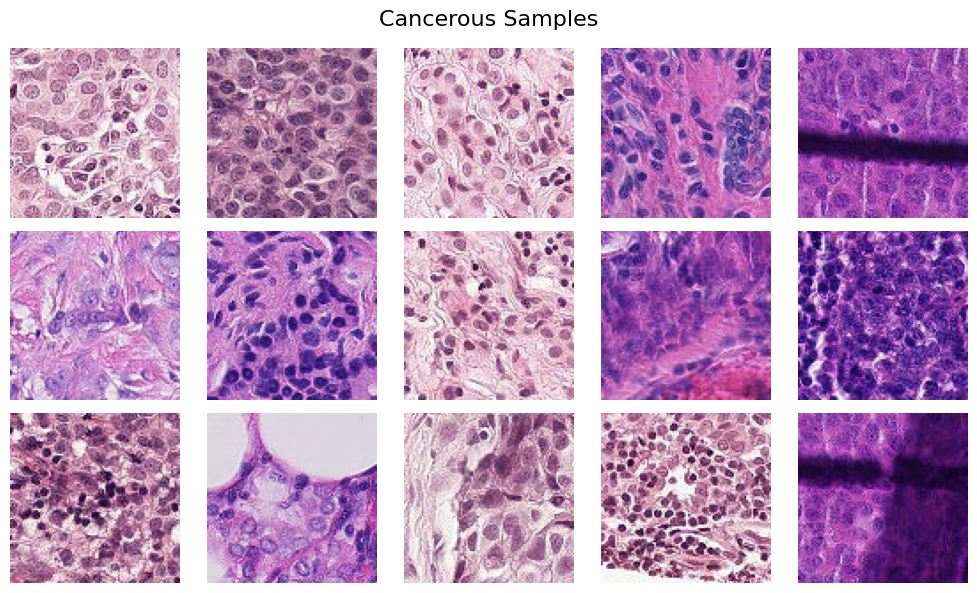

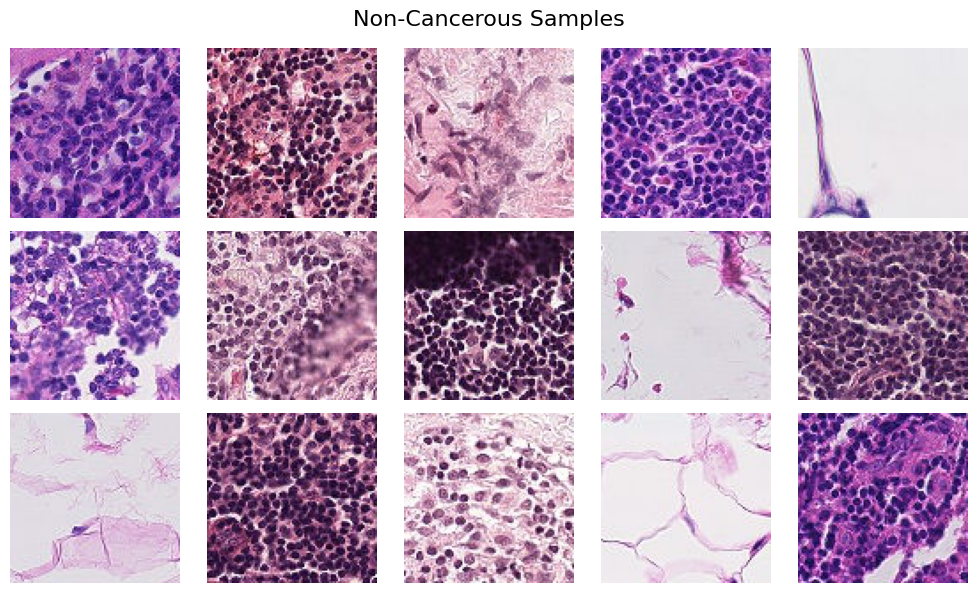

In [4]:
#Image Analysis
#Random Sample Visualization

# This shows the visual differences in texture , straining and structure between classes
#Helps build intution for model building and preprocessing

cancer_ids = df[df['label'] == 1]['id'].values
non_cancer_ids = df[df['label'] == 0]['id'].values

def plot_image_grid(image_ids, title, n_rows=3, n_cols=5):
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i, img_id in enumerate(random.sample(list(image_ids), n_rows * n_cols)):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif"
        img = Image.open(img_path)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot grids
plot_image_grid(cancer_ids, "Cancerous Samples")
plot_image_grid(non_cancer_ids, "Non-Cancerous Samples")

In [5]:
# Collect the pixel intensity values from Red,Green and Blue channels for sample 500 images

def get_channel_stats(image_ids, sample_size=500):
    stats = {'R': [], 'G': [], 'B': []}
    for img_id in image_ids[:sample_size]:
        path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif"
        img = Image.open(path)
        arr = np.array(img)
        for i, channel in enumerate(['R', 'G', 'B']):
            stats[channel].extend(arr[:, :, i].flatten())
    return stats

In [6]:
#Load the first 500 samples(cancerous& non cancerous) and extracts R,G and B pixel values and stores them in a dictionary
cancer_stats = get_channel_stats(cancer_ids, sample_size=500)
non_cancer_stats = get_channel_stats(non_cancer_ids, sample_size=500)

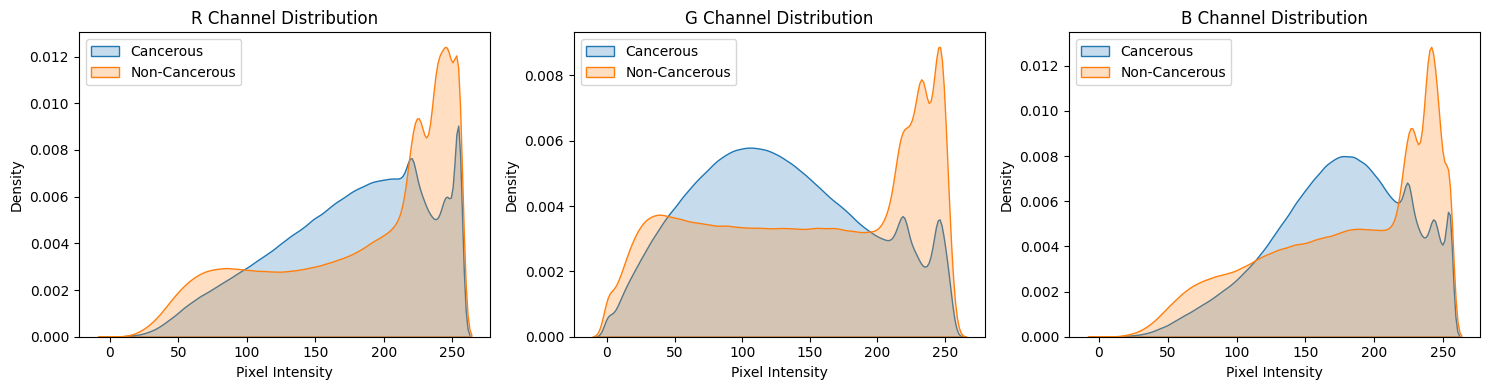

In [9]:
#kdes - To plot the R,G and B density across (how they are spread) from 0 to 255 intensity range

def plot_channel_distributions(stats1, stats2, label1, label2):
    plt.figure(figsize=(15, 4))
    for i, channel in enumerate(['R', 'G', 'B']):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(stats1[channel], label=label1, fill=True)
        sns.kdeplot(stats2[channel], label=label2, fill=True)
        plt.title(f'{channel} Channel Distribution')
        plt.xlabel('Pixel Intensity')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_channel_distributions(cancer_stats, non_cancer_stats, 'Cancerous', 'Non-Cancerous')


warnings.filterwarnings("ignore")

From the above kde plot, we can infer the following:

R channel distribution - Cancerous tissue tends to have a higher density(has more pixels)
in the higher pixel range(medium to bright red) and Non-Cancerous tissue shows a broader spread
shows a broader spread with more density in the high pixel range.(darker or less red 
overall)

G channel distribution - Cancerous tissue is evenly spraed and Non-Cancerous tissue has sharp 
peak in the high intensity range

B channel distribution - Cancerous tissue is concentrated at the high intensity range
and non- cancerous tissue is concentrated at the high pixel intensity

In [7]:
#Summary statistics - To print the standard deviation and mean across teh RGB channels 

for channel in ['R', 'G', 'B']:
    print(f"\n{channel} Channel:")
    print("Cancerous - Mean:", np.mean(cancer_stats[channel]), 
          "\n Std:", np.std(cancer_stats[channel]), 
          "\nMin:", np.min(cancer_stats[channel]), 
          "\nMax:", np.max(cancer_stats[channel]))
    print("Non-Cancerous - Mean:", np.mean(non_cancer_stats[channel]), 
          "\n Std:", np.std(non_cancer_stats[channel]), 
          "\n Min:", np.min(non_cancer_stats[channel]), 
          "\n Max:", np.max(non_cancer_stats[channel]))



R Channel:
Cancerous - Mean: 174.63917144097223 
 Std: 54.811886801089365 
Min: 0 
Max: 255
Non-Cancerous - Mean: 181.29825303819445 
 Std: 64.7356470074711 
 Min: 0 
 Max: 255

G Channel:
Cancerous - Mean: 127.32083051215278 
 Std: 62.71396574812603 
Min: 0 
Max: 255
Non-Cancerous - Mean: 146.35671961805556 
 Std: 76.57620475575067 
 Min: 0 
 Max: 255

B Channel:
Cancerous - Mean: 174.01797005208334 
 Std: 48.07501384458552 
Min: 0 
Max: 255
Non-Cancerous - Mean: 178.78030902777778 
 Std: 59.475458507658175 
 Min: 0 
 Max: 255


Cancerous tissues tend to have lower mean intensity than non cancerous 
tissues across all RGB channels.All channels fall in the full intensity range 
but the non-cancerous tissues have higher standard deviation.

# 3.Data Preprocessing

In [9]:
#Splitting into test and train dataset
import os
import pandas as pd
from glob import glob


base_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
df_train = pd.DataFrame({'path': glob(os.path.join(base_dir, '*.tif'))})

labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_train['id'] = df_train['path'].map(lambda x: os.path.basename(x).replace('.tif', ''))
df_train = df_train.merge(labels, on='id', how='left')

print(df_train.head(5))

                                                path  \
0  /kaggle/input/histopathologic-cancer-detection...   
1  /kaggle/input/histopathologic-cancer-detection...   
2  /kaggle/input/histopathologic-cancer-detection...   
3  /kaggle/input/histopathologic-cancer-detection...   
4  /kaggle/input/histopathologic-cancer-detection...   

                                         id  label  
0  d43c081bafa286f9c1f7e921883f26ceafebc912      1  
1  092d0eedebce504847715ee046b6ad74b57599b4      0  
2  b0d2582c6218a8764323fc940b41312282b99bf4      0  
3  187c99df762f13f99818e5593d4bab4c6577e7e3      1  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53      1  


In [10]:
df_train.shape

(220025, 3)

In [11]:
#Taking 10000 samples for faster processing
from sklearn.model_selection import train_test_split

df_new = df_train.sample(n=10000, random_state=2018)

train, valid = train_test_split(df_new,test_size=0.2)

In [12]:
#12000 samples for Resnet Model

from sklearn.model_selection import train_test_split

df_new = df_train.sample(n=120000, random_state=2018)

train1, valid1 = train_test_split(df_new,test_size=0.2)

In [13]:
print(train.shape)
print(valid.shape)

(8000, 3)
(2000, 3)


In [14]:
print(train1.shape)
print(valid1.shape)

(96000, 3)
(24000, 3)


In [15]:
#Converting labels to strings to avoid confusion

train['label'] = train['label'].astype('str')
valid['label'] = valid['label'].astype('str')

train1['label'] = train1['label'].astype('str')
valid1['label'] = valid1['label'].astype('str')

In [16]:
#Generators - since we are processing with so many images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagenerator = ImageDataGenerator(rescale=1.0/255) #Normalize the images

train_generator = datagenerator.flow_from_dataframe(dataframe = train, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (96,96),
                                                    class_mode = "binary",
                                                    batch_size=32,
                                                    seed = 110318,
                                                    shuffle = True)

valid_generator = datagenerator.flow_from_dataframe(dataframe = valid,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (96,96),
                                                   class_mode = 'binary',
                                                   batch_size = 32,
                                                   shuffle = False)




2025-10-30 17:34:42.046022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761845682.229861      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761845682.289171      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [17]:
train_generator1 = datagenerator.flow_from_dataframe(dataframe = train1, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (96,96),
                                                    class_mode = "binary",
                                                    batch_size=32,
                                                    seed = 110318,
                                                    shuffle = True)

valid_generator1 = datagenerator.flow_from_dataframe(dataframe = valid1,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (96,96),
                                                   class_mode = 'binary',
                                                   batch_size = 32,
                                                   shuffle = False)

Found 96000 validated image filenames belonging to 2 classes.
Found 24000 validated image filenames belonging to 2 classes.


# 4.Model Architecture

In [18]:
#Model Architectre
#Fixed CNN Architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model
model = Sequential([
    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 4th Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761845909.816171      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,961 (3.48 MB)

 Trainable params: 912,961 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=3,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


I0000 00:00:1761845925.386803     107 service.cc:148] XLA service 0x7f9d30010970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761845925.387739     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761845925.859839     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/250 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6944 - loss: 0.6588

I0000 00:00:1761845930.961556     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.6146 - loss: 0.6441 - val_accuracy: 0.6685 - val_loss: 0.6038
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7437 - loss: 0.5452 - val_accuracy: 0.7885 - val_loss: 0.4957
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.7664 - loss: 0.5092 - val_accuracy: 0.7660 - val_loss: 0.5025


In [20]:
#Final Validation Accuracy - Sequential Model

loss, accuracy = model.evaluate(valid_generator, steps=len(valid_generator), verbose=1)
print(f"Final Validation Accuracy: {accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7530 - loss: 0.5209
Final Validation Accuracy: 0.7660


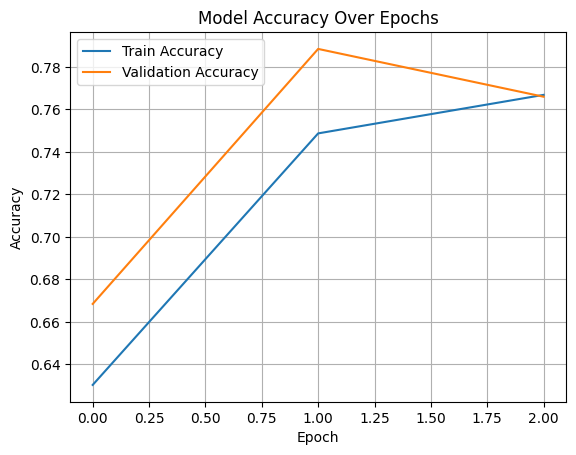

In [21]:
#Plot accuracy over epochs

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The above plot compares the training and validation aaccuracy across 3 epochs.
-Training accuracy increases from 0.64 to 0.76 across epochs which indicates the model is learning 
from the training data.
-Validation accuracy jumps quickly from 0.66 to 0.78 by epoch 1 and slightly dips to 0.76 at epoch 2

Keras Tuner - Hyperparameter Optimization Framework for deep learning models in keras and TensorFlow

In [34]:
!python --version

Python 3.12.11


In [ ]:
!pip install keras-tuner



# 5.Hyperparameter Tuning 

In [22]:

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam


In [23]:
# Tunable CNN with Keras Tuner

def build_model(hp):
    kernel_size_choice = hp.Choice('kernel_size', [3, 5])
    kernel_size = (kernel_size_choice, kernel_size_choice)

    model = Sequential()
    
    # Input + 1st Conv Block
    model.add(Conv2D(
        filters=hp.Choice('conv_1_filters', [32, 64]),
        kernel_size=kernel_size,
        activation='relu',
        input_shape=(96, 96, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
    
    # 2nd Conv Block
    model.add(Conv2D(
        filters=hp.Choice('conv_2_filters', [64, 128]),
        kernel_size=kernel_size,
        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))
    
    # 3rd Conv Block
    model.add(Conv2D(
        filters=hp.Choice('conv_3_filters', [128, 256]),
        kernel_size=kernel_size,
        activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)))
    
    # Fully Connected
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', [64, 128, 256]),
        activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', 0.3, 0.6, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

 
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='cnn_tuning'
)

tuner.search(train_generator,
             validation_data=valid_generator,
             epochs=2,
             steps_per_epoch=len(train_generator),
             validation_steps=len(valid_generator))

Trial 5 Complete [00h 00m 39s]
val_accuracy: 0.6085000038146973

Best val_accuracy So Far: 0.7914999723434448
Total elapsed time: 00h 03m 13s


In [25]:

#RESNET MODEL

from tensorflow.keras import layers, models, Input

def resnet_block(x, filters, downsample=False):
    shortcut = x

    stride = 2 if downsample else 1

    # First conv layer
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second conv layer
    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut if downsampling
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add residual connection
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [26]:
def build_resnet(input_shape=(96, 96, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Initial conv
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, downsample=True)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, downsample=True)
    x = resnet_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name="ResNetBinaryClassifier")
    return model

In [27]:
resnetmodel = build_resnet()
resnetmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
resnetmodel.summary()

Model: "ResNetBinaryClassifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 24, 24,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 24,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 24, 24,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 24, 24,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_7[0][0]  

 Total params: 2,822,529 (10.77 MB)

 Trainable params: 2,818,049 (10.75 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [28]:
#Train RESNET MODEL

history = resnetmodel.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=3,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    verbose=1
)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.7231 - loss: 0.6047 - val_accuracy: 0.4780 - val_loss: 1.3735
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.7999 - loss: 0.4573 - val_accuracy: 0.6785 - val_loss: 0.6603
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8057 - loss: 0.4506 - val_accuracy: 0.7945 - val_loss: 0.4601


In [29]:
#Evaluate Accuracy

loss, accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print(f"Validation Accuracy: {accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7530 - loss: 0.5209
Validation Accuracy: 0.7660


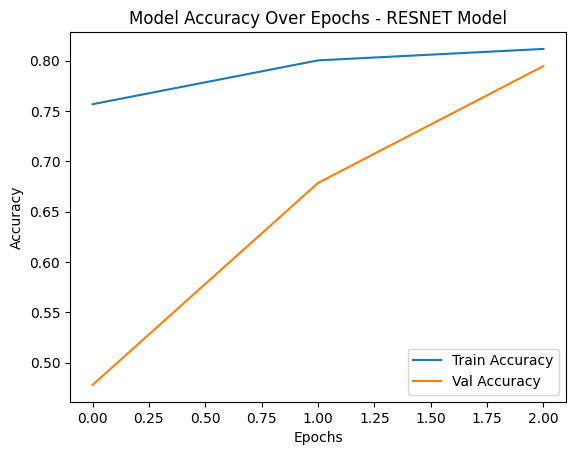

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs - RESNET Model')
plt.show()

From the above plot, we can see that the 
- Training Accuracy starts high (~0.76) and increases slightly, ending just above 0.80.
- Validation Accuracy starts low (~0.48) but climbs steadily, nearly matching training accuracy by epoch 3.

In [33]:
#Hyperparameter Tuning

import pandas as pd

# Replace these with your actual evaluated accuracies
sequential_acc = 0.76
tuner_acc = 0.79
resnet_acc = 0.76

# Create a DataFrame
accuracy_table = pd.DataFrame({
    'Model': ['Sequential CNN', 'Tuner Model', 'ResNet'],
    'Validation Accuracy': [sequential_acc, tuner_acc, resnet_acc]
})

# Display the table
print(accuracy_table)

            Model  Validation Accuracy
0  Sequential CNN                 0.76
1     Tuner Model                 0.79
2          ResNet                 0.76


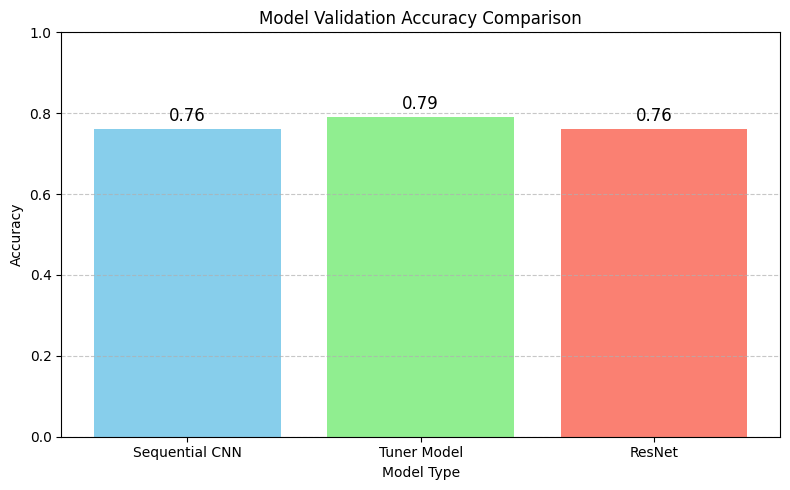

In [34]:
#Plot

plt.figure(figsize=(8, 5))
plt.bar(accuracy_table['Model'], accuracy_table['Validation Accuracy'], color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for i, acc in enumerate(accuracy_table['Validation Accuracy']):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
AUC: 0.8565


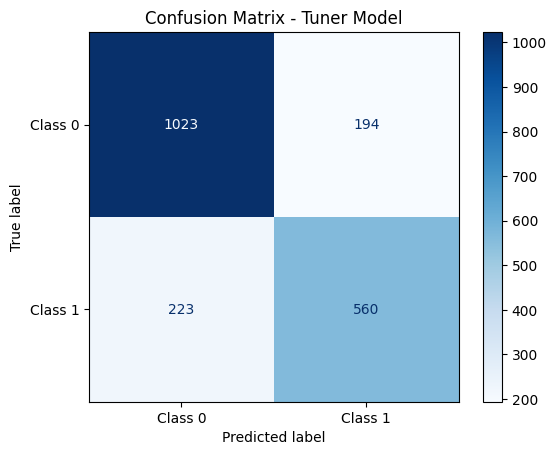

In [39]:
#Tuner Model - AUC score and Confusion Matrix

from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get best model from tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Predict probabilities
y_pred_prob = best_model.predict(valid_generator, steps=len(valid_generator)).flatten()

# True labels (make sure generator has shuffle=False)
y_true = valid_generator.classes

# AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC: {auc:.4f}")

# Confusion Matrix
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Tuner Model')
plt.show()

# 6.Submissions

In [ ]:
#Submissions

import os
import pandas as pd

# Path to test images
test_dir = '../input/histopathologic-cancer-detection/test'

# List all image filenames
test_filenames = os.listdir(test_dir)

# Create DataFrame
test_df = pd.DataFrame({
    'id': [f.replace('.tif', '') for f in test_filenames],
    'path': [os.path.join(test_dir, f) for f in test_filenames]
})
test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col=None,  # No labels for test set
    target_size=(96, 96),
    class_mode=None,
    batch_size=32,
    shuffle=False
)

pred_probs = best_model.predict(test_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

submission = pd.DataFrame({
    'id': test_df['id'],  # or 'filename' depending on Kaggle format
    'label': pred_labels
})

submission.to_csv('submission.csv', index=False)

#Final Score:0.77

# 7.Conclusion

Cancer detection datastes has lots of images.This is a binary image classification project which indicates if cancer is present or not.

**Deep CNN Model:**

This dataset is first trained using deep CNN model with input size(96,96,3).It stacks four convolution blocks with increasing filters (32-256) each followed by max
pooling and dropout for regularization.After flattening, it uses 2 dense layers (28 units + sigmoid) to output a probability for the target class.

Validation accuracy for this model is 0.76

- Good Generalization: The training and validation accuracies converge around 0.76 at epoch 2, suggesting the model is not overfitting.
- Slight Dip in Validation Accuracy: The small drop from epoch 1 to 2 could indicate early signs of overfitting or just natural fluctuation due to batch variation.

**Keras Tuner (Hyperparameter optimization)**

This function defines a tunable CNN architecture using Keras Tuner, where key hyperparameters like filter sizes, kernel dimensions, dropout rates, dense units, and learning rate are dynamically selected. It builds a 3-block convolutional model followed by a fully connected layer for binary classification. The model is compiled with Adam optimizer and binary crossentropy loss, ready for hyperparameter search.

Validation accuracy for this: 0.79

**RESNET MODEL:**
.
This function defines a ResNet-style residual block that applies two convolutional layers with batch normalization and ReLU activation. 

Validation accuracy for this: 0.76

Among the 3 models,Keras Tuner(Hyperparameter tuning) performs slightly better than the other 2 models.
Also, note that the number of images taken for processing is low (~12000) .

For furthur precise accuracy, the number of epochs has to be increased and furthur fine tuning has to be done.Also , the number of images in the batches can be increased.

For a CNN model, hyperparameters like filter sizes,number of layers,dropout rates,learning arte,batch size and activation layers can be furthur tuned .

Final Submission Accuracy: 0.77

# 8.References:

1. https://www.geeksforgeeks.org/deep-learning/keras-tuner-for-hyperparameter-optimization/
2. https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/
